# PROBLEM


Target Variable (sii) is defined as:
- 0: None (PCIAT-PCIAT_Total from 0 to 30)
- 1: Mild (PCIAT-PCIAT_Total from 31 to 49)
- 2: Moderate (PCIAT-PCIAT_Total from 50 to 79)
- 3: Severe (PCIAT-PCIAT_Total 80 and more)
This makes sii an ordinal categorical variable with four levels, where the order of categories is meaningful.

Approaches to Modeling SII as the Target Variable
1. Multiclass classification (treat sii as a nominal categorical variable without considering the order)
2. Regression (ignore the discrete nature of categories and treat sii as a continuous variable, then round prediction)
We can also use `PCIAT-PCIAT_Total` as a continuous target variable, and implement regression on `PCIAT-PCIAT_Total` and then map predictions to sii categories.
- **In this project, the primary focus will be on classification models to directly predict SII categories.**

# Exploratory Data Analysis

- Load Python Libraries

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgb
from colorama import Fore, Style
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from catboost import CatBoostRegressor
from sklearn.impute import  KNNImputer
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
path = kagglehub.dataset_download("ryati131457/pytorchtabnet")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pytorchtabnet


# Data Processing Pipeline

##  Data Ingestion

- Load data from file

In [2]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [3]:
train.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,740.000000,740.000000,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2733.000000,2734.000000,2731.000000,2731.000000,2729.000000,2732.000000,2729.000000,2730.000000,2730.000000,2733.000000,2734.000000,2731.000000,2729.000000,2732.000000,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,7.370270,27.581081,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,2.178853,2.589550,2.370655,2.177762,2.399854,0.839253,2.297545,1.063690,0.586295,1.246520,1.062637,1.304793,1.685443,0.244599,1.340051,1.035505,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,3.189662,17.707751,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.849476,0.783937,1.673312,1.697117,1.588807,1.195601,1.705218,1.268282,1.049355,1.342582,1.258797,1.331715,1.543074,0.522956,1.411156,1.301712,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.660000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000

In [4]:
display(train.head())
print(f"Train shape: {train.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 82)


In [5]:
display(test.head())
print(f"Test shape: {test.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test shape: (20, 59)


In [6]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


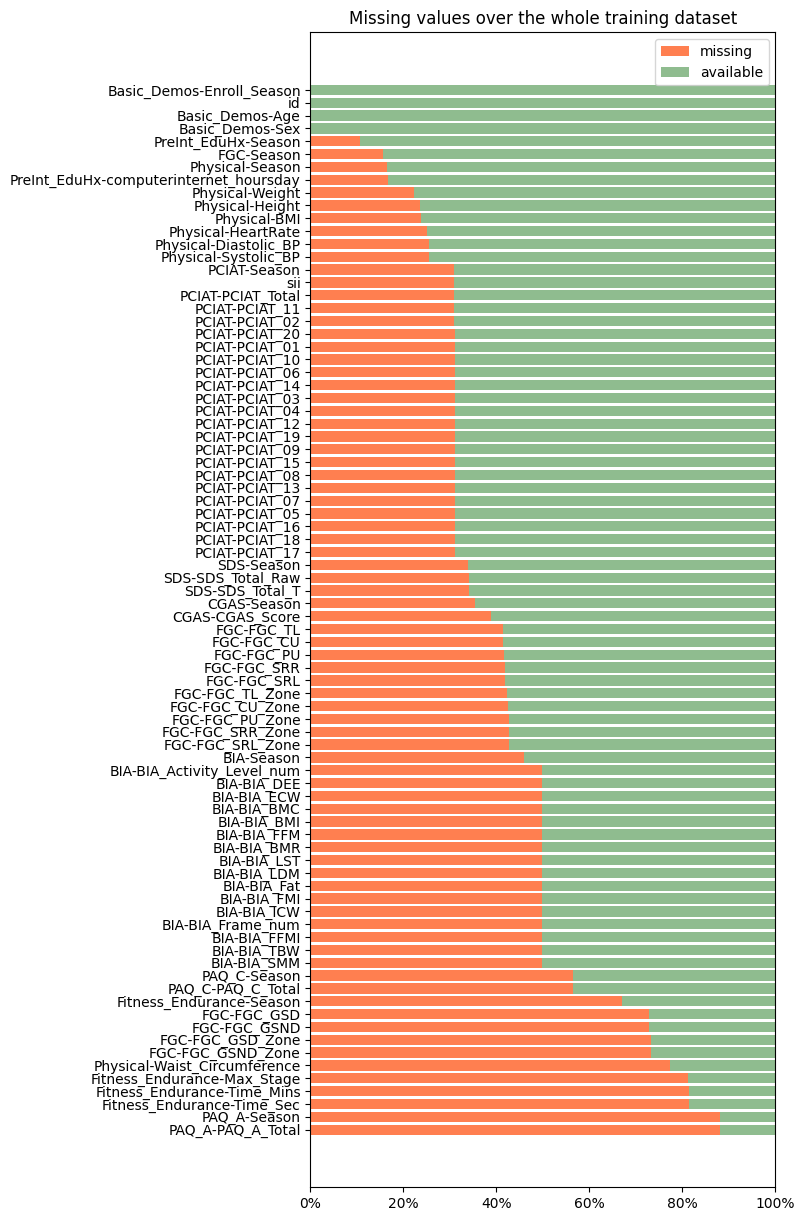

In [7]:
missing_count = (
    train.isnull().sum()
    .reset_index()
    .rename(columns={'index': 'feature', 0: 'null_count'})
)

missing_count['null_ratio'] = missing_count['null_count'] / len(train)

missing_count = missing_count.sort_values(by='null_count', ascending=False)

plt.figure(figsize=(6, 15))
plt.title('Missing values over the whole training dataset')

plt.barh(
    y=np.arange(len(missing_count)), 
    width=missing_count['null_ratio'], 
    color='coral', 
    label='missing'
)

plt.barh(
    y=np.arange(len(missing_count)), 
    width=1 - missing_count['null_ratio'], 
    left=missing_count['null_ratio'], 
    color='darkseagreen', 
    label='available'
)

plt.yticks(np.arange(len(missing_count)), missing_count['feature'])
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()

# plt.savefig('missing_values.png', dpi=300, bbox_inches='tight')

plt.show()



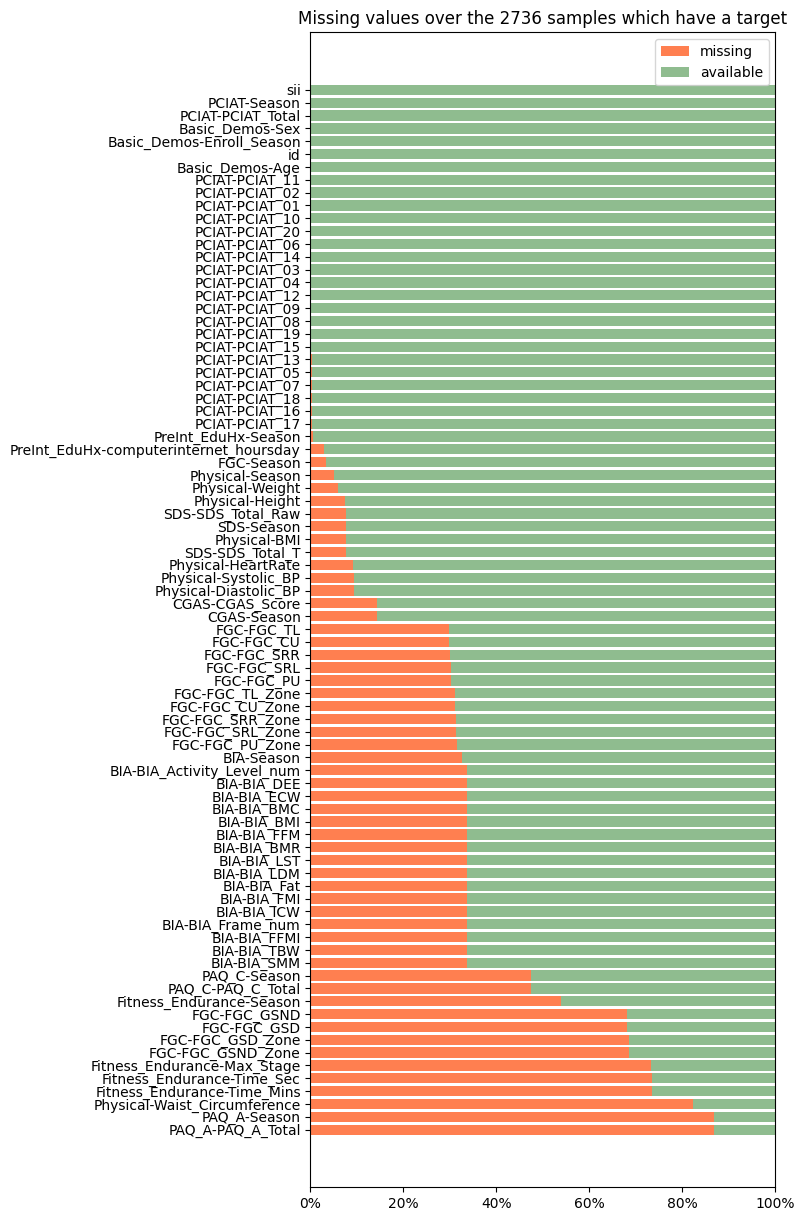

In [8]:
supervised_usable = train[train['sii'].notnull()]

missing_count = (
    supervised_usable.isnull().sum()
    .reset_index()  # Chuyển đổi thành DataFrame
    .rename(columns={'index': 'feature', 0: 'null_count'})
)

missing_count['null_ratio'] = missing_count['null_count'] / len(supervised_usable)

missing_count = missing_count.sort_values(by='null_count', ascending=False)


plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')

plt.barh(
    y=np.arange(len(missing_count)), 
    width=missing_count['null_ratio'], 
    color='coral', 
    label='missing'
)

plt.barh(
    y=np.arange(len(missing_count)), 
    width=1 - missing_count['null_ratio'], 
    left=missing_count['null_ratio'], 
    color='darkseagreen', 
    label='available'
)

plt.yticks(np.arange(len(missing_count)), missing_count['feature'])
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

In [9]:
result = (
    train.groupby('sii')['PCIAT-PCIAT_Total']
    .agg([
        ('PCIAT-PCIAT_Total min', 'min'),
        ('PCIAT-PCIAT_Total max', 'max'),
        ('count', 'size')
    ])
    .reset_index()
    .sort_values(by='sii')
)

print(result)

   sii  PCIAT-PCIAT_Total min  PCIAT-PCIAT_Total max  count
0  0.0                    0.0                   30.0   1594
1  1.0                   31.0                   49.0    730
2  2.0                   50.0                   79.0    378
3  3.0                   80.0                   93.0     34


In [10]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


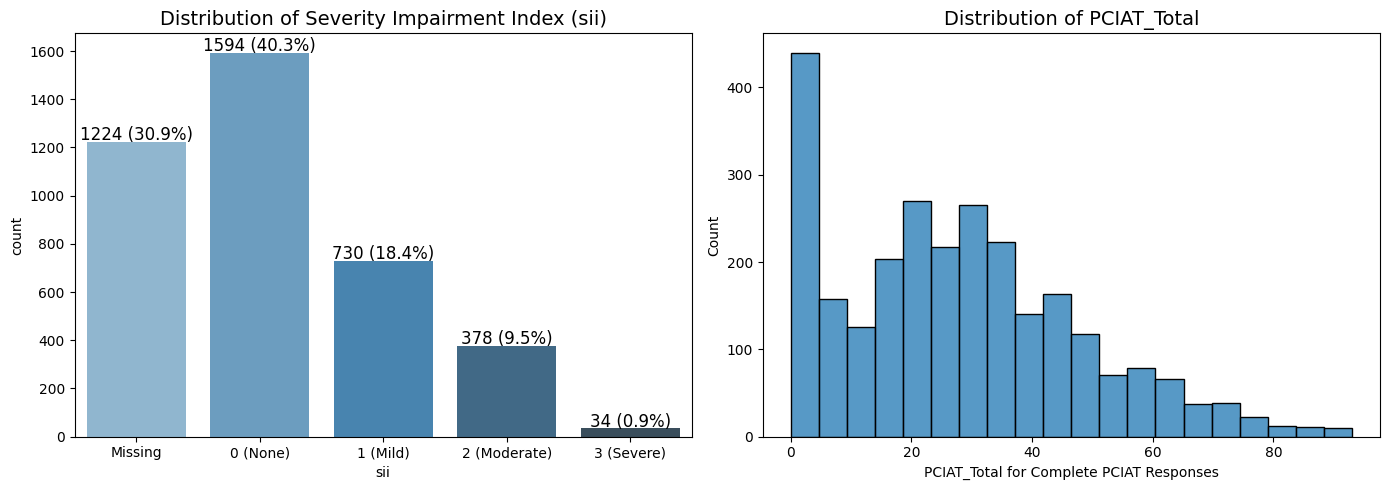

In [11]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]

train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

sii_counts = train['sii'].value_counts().reset_index()
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

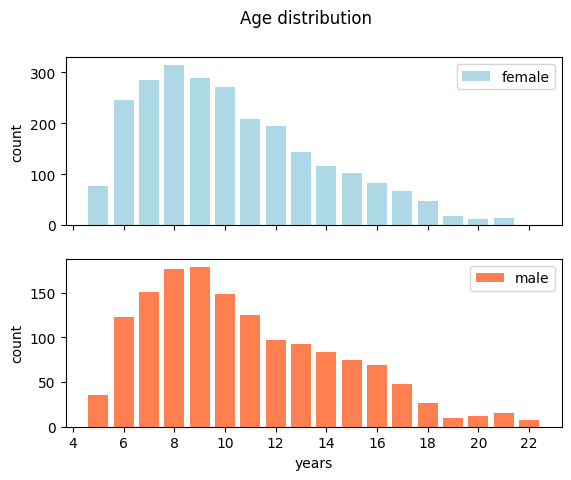

In [12]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs[sex]
    
    vc = (
        train[train['Basic_Demos-Sex'] == sex]
        ['Basic_Demos-Age']
        .value_counts()
        .sort_index()
    )    
    ax.bar(vc.index, vc.values, color=['lightblue', 'coral'][sex], label=['female', 'male'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs[1].set_xlabel('years')
plt.show()

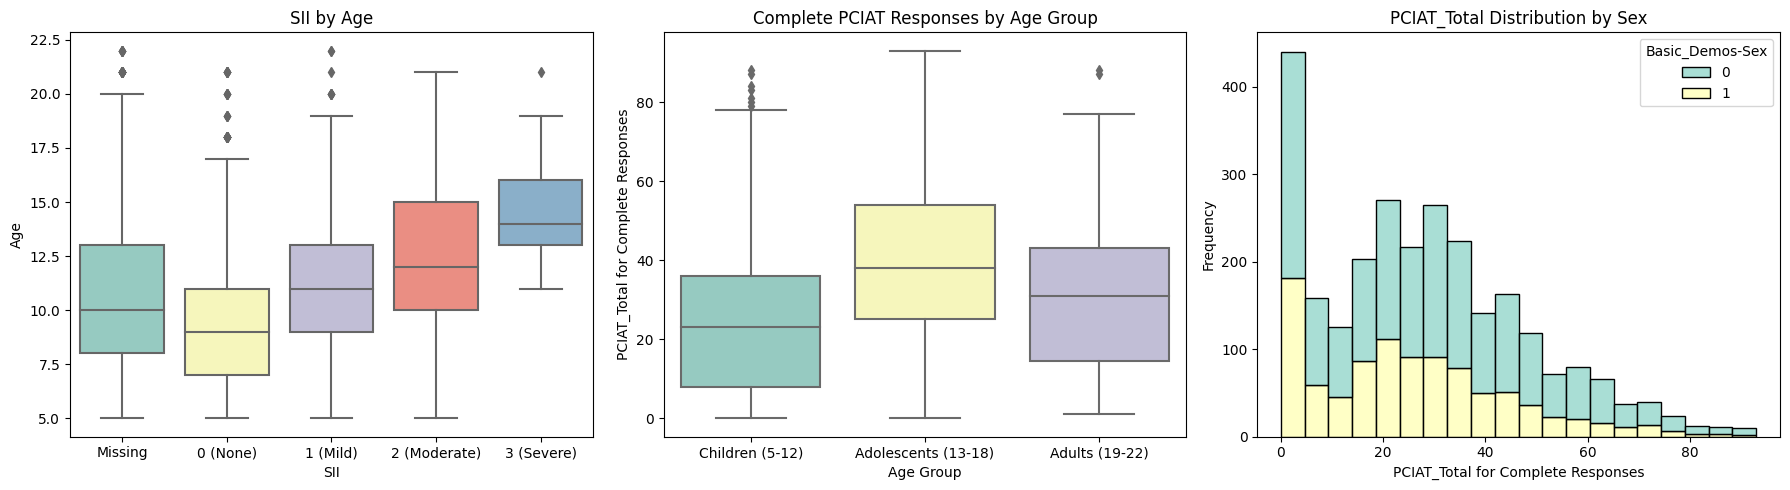

In [13]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SII by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['sii'], ax=axes[0], palette="Set3")
axes[0].set_title('SII by Age')
axes[0].set_ylabel('Age')
axes[0].set_xlabel('SII')

# Complete PCIAT Responses by Age Group
sns.boxplot(
    x='Age Group', y='complete_resp_total',
    data=train, palette="Set3", ax=axes[1]
)
axes[1].set_title('Complete PCIAT Responses by Age Group')
axes[1].set_ylabel('PCIAT_Total for Complete Responses')
axes[1].set_xlabel('Age Group')

# PCIAT_Total by Sex
sns.histplot(
    data=train, x='complete_resp_total',
    hue='Basic_Demos-Sex', multiple='stack',
    palette="Set3", bins=20, ax=axes[2]
)
axes[2].set_title('PCIAT_Total Distribution by Sex')
axes[2].set_xlabel('PCIAT_Total for Complete Responses')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

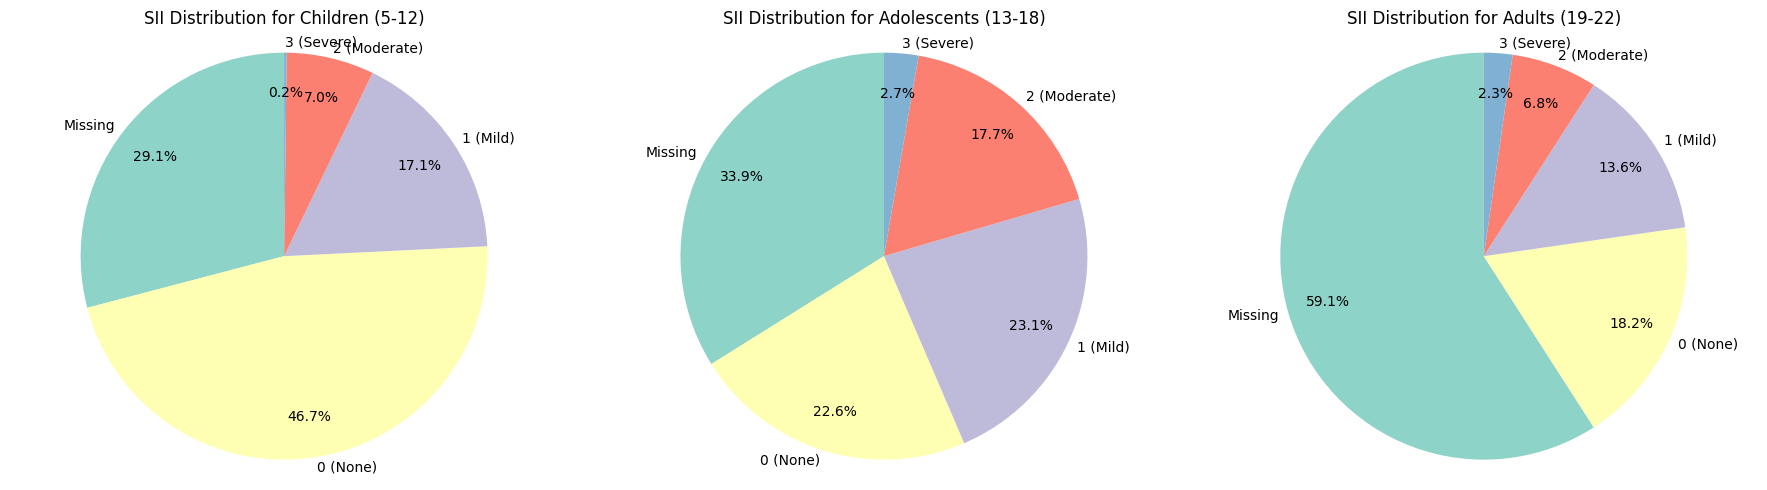

In [14]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

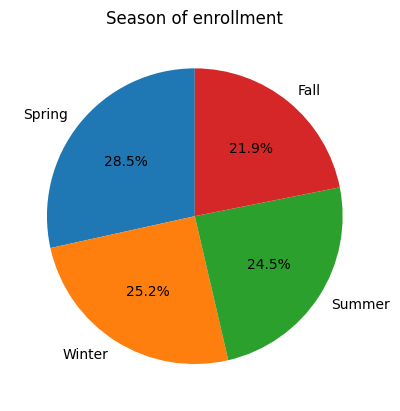

In [15]:
vc = train['Basic_Demos-Enroll_Season'].value_counts()
plt.pie(vc.values, labels=vc.index, autopct='%1.1f%%', startangle=90)
plt.title('Season of enrollment')
plt.show()

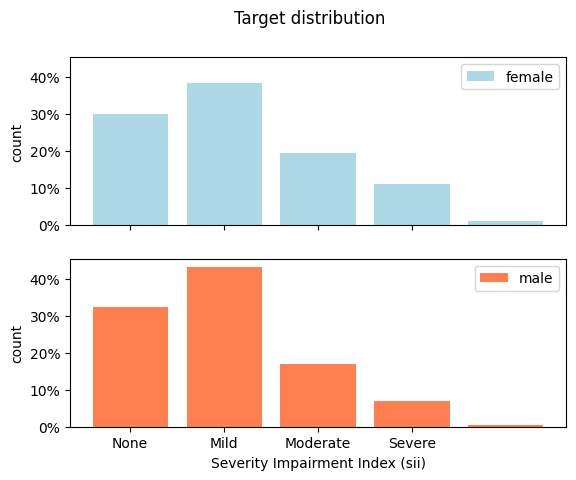

In [16]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs[sex]
    vc = (
        train[train['Basic_Demos-Sex'] == sex]
        ['sii']
        .value_counts(normalize = True)
        .sort_index()
    )
    
    ax.bar(vc.index, vc.values, color=['lightblue', 'coral'][sex], label=['female', 'male'][sex])
    ax.set_xticks(np.arange(len(target_labels)))
    ax.set_xticklabels(target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

In [17]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

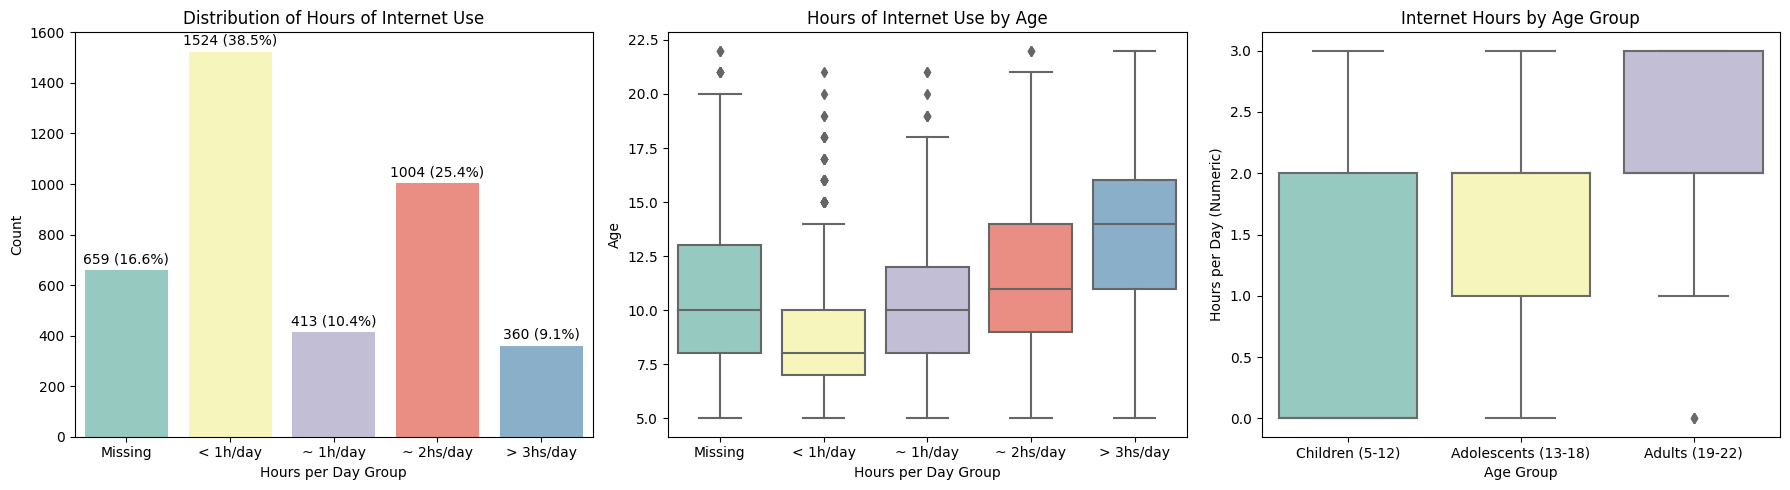

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hours of Internet Use
ax1 = sns.countplot(x='internet_use_encoded', data=train, palette="Set3", ax=axes[0])
axes[0].set_title('Distribution of Hours of Internet Use')
axes[0].set_xlabel('Hours per Day Group')
axes[0].set_ylabel('Count')

total = len(train['internet_use_encoded'])
for p in ax1.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax1.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# Hours of Internet Use by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['internet_use_encoded'], ax=axes[1], palette="Set3")
axes[1].set_title('Hours of Internet Use by Age')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Hours per Day Group')

# Hours of Internet Use (numeric) by Age Group
sns.boxplot(y='PreInt_EduHx-computerinternet_hoursday', x='Age Group', data=train, ax=axes[2], palette="Set3")
axes[2].set_title('Internet Hours by Age Group')
axes[2].set_ylabel('Hours per Day (Numeric)')
axes[2].set_xlabel('Age Group')

plt.tight_layout()
plt.show()

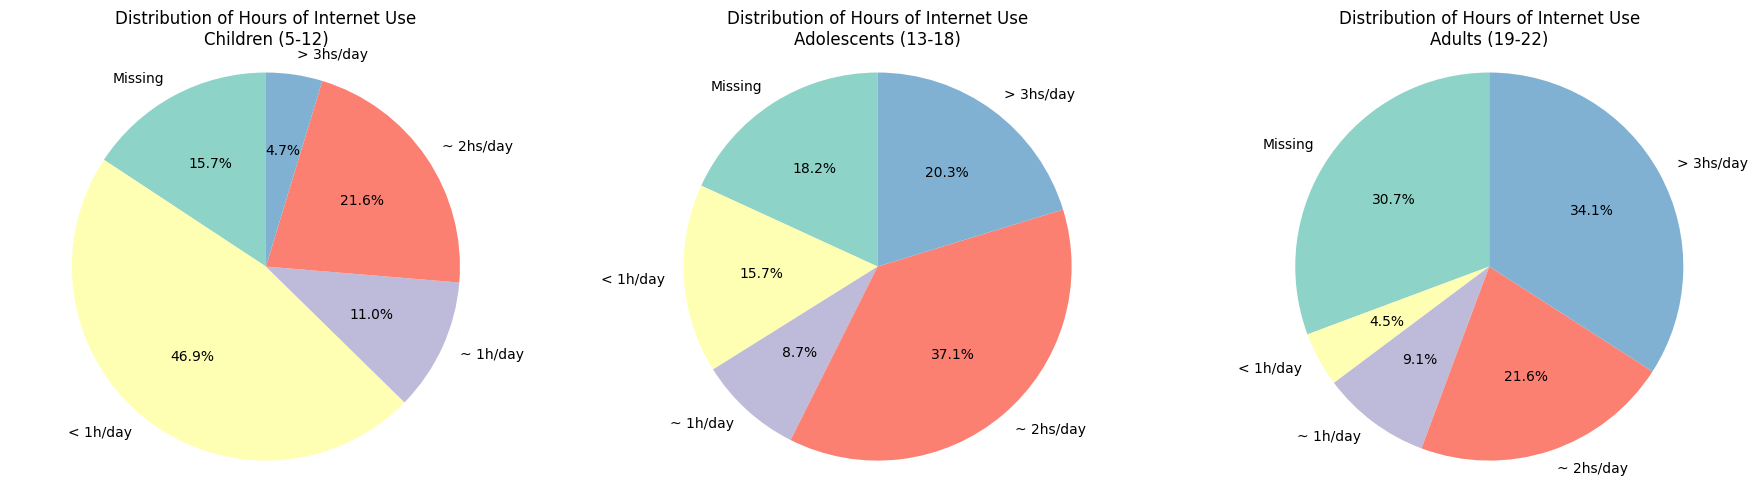

In [19]:
stats = train.groupby(
    ['Age Group', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(group_counts, labels=group_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1)
    axes[i].set_title(f'Distribution of Hours of Internet Use\n{age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [20]:
sii_reported = train[train['sii'] != "Missing"]

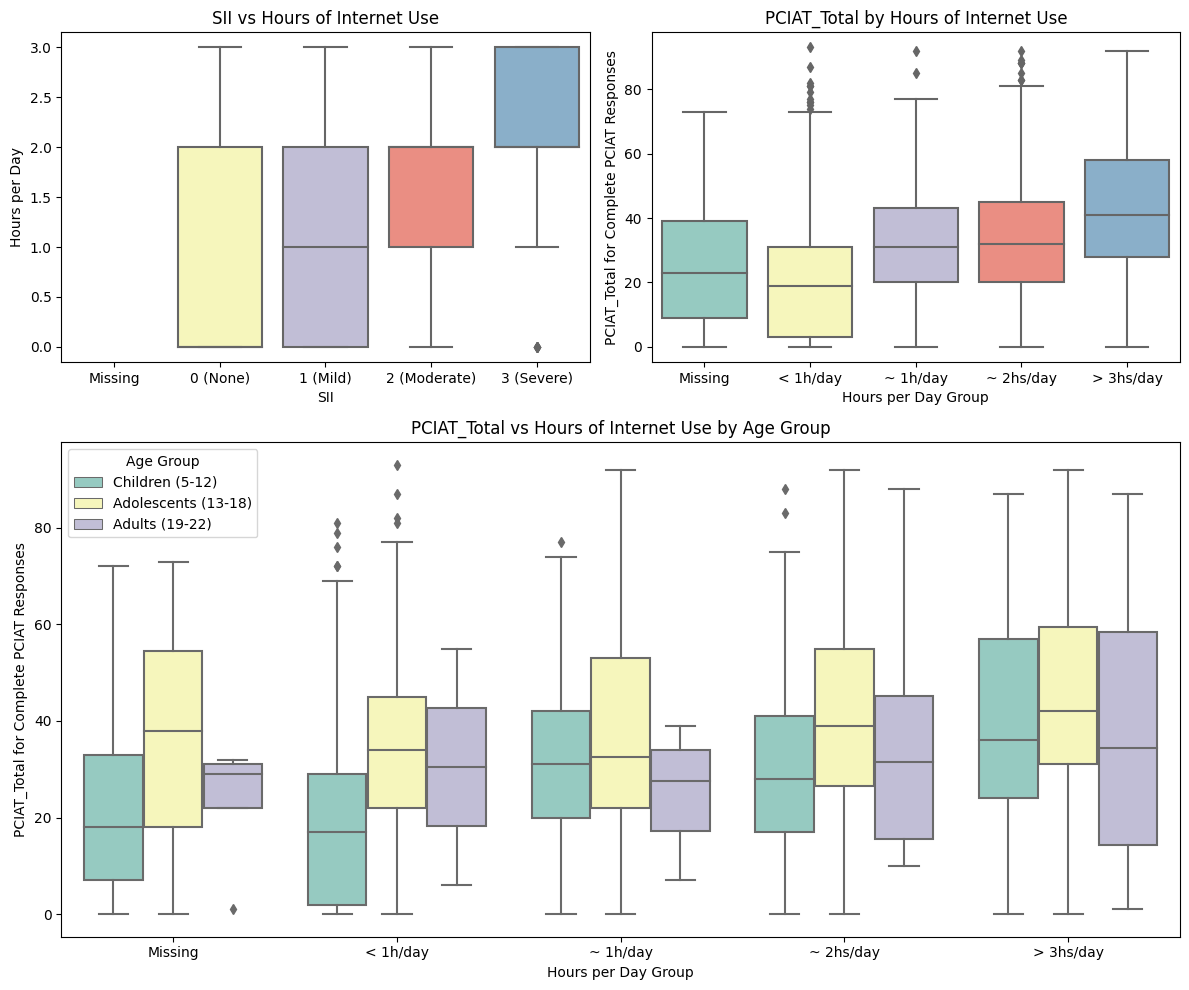

In [21]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])

# SII vs Hours of Internet Use
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(
    x='sii', y='PreInt_EduHx-computerinternet_hoursday',
    data=sii_reported,
    ax=ax1, palette="Set3"
)
ax1.set_title('SII vs Hours of Internet Use')
ax1.set_ylabel('Hours per Day')
ax1.set_xlabel('SII')

# PCIAT_Total for Complete PCIAT Responses by Hours of Internet Use
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    palette="Set3", ax=ax2
)
ax2.set_title('PCIAT_Total by Hours of Internet Use')
ax2.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax2.set_xlabel('Hours per Day Group')

# SII vs Hours of Internet Use by Age Group (Full width)
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    hue='Age Group', ax=ax3, palette="Set3"
)
ax3.set_title('PCIAT_Total vs Hours of Internet Use by Age Group')
ax3.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax3.set_xlabel('Hours per Day Group')

plt.tight_layout()
plt.show()

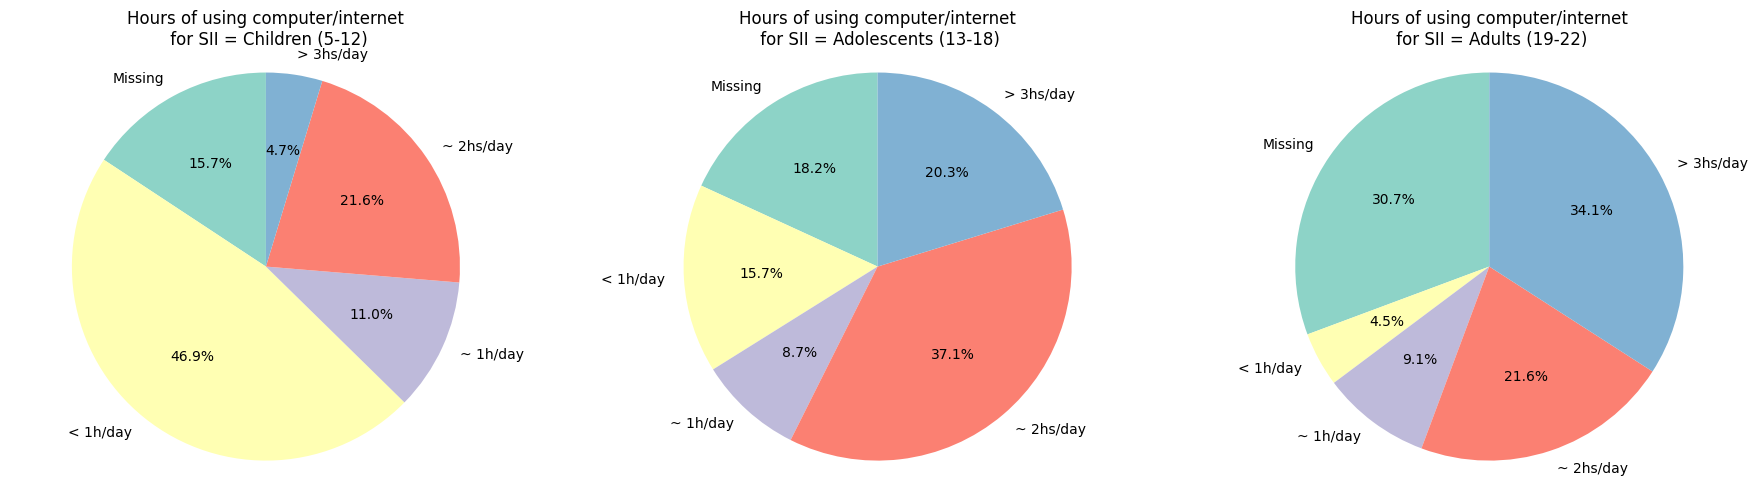

In [22]:
if len(stats.index) > 1:
    fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))
else:
    fig, axes = plt.subplots(figsize=(18, 5))  # Single group case

for i, sii_group in enumerate(stats.index):
    group_counts = stats.loc[sii_group] / stats.loc[sii_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1
    )
    axes[i].set_title(f'Hours of using computer/internet\n for SII = {sii_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

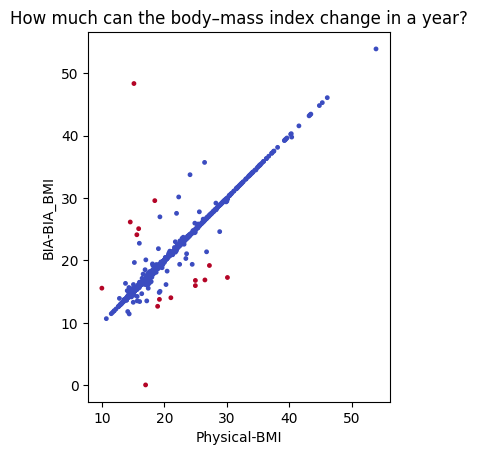

In [23]:
bmi_ratio = train['Physical-BMI'] / train['BIA-BIA_BMI']

color = (bmi_ratio < 0.7) | (bmi_ratio > 1.3)

plt.scatter(train['Physical-BMI'],
            train['BIA-BIA_BMI'],
            s=6,
            c=color,
            cmap='coolwarm')

plt.gca().set_aspect('equal')

plt.xlabel('Physical-BMI')
plt.ylabel('BIA-BIA_BMI')
plt.title('How much can the body–mass index change in a year?')

plt.show()

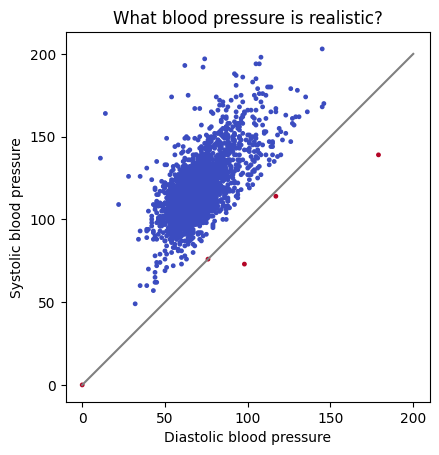

In [24]:
color = train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP']

plt.scatter(train['Physical-Diastolic_BP'],
            train['Physical-Systolic_BP'],
            s=6,
            cmap='coolwarm',
            c=color)
plt.gca().set_aspect('equal')
plt.plot([0, 200], [0, 200], color='gray')
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Systolic blood pressure')
plt.title('What blood pressure is realistic?')
plt.xticks(np.linspace(0, 200, 5))
plt.yticks(np.linspace(0, 200, 5))
plt.show()

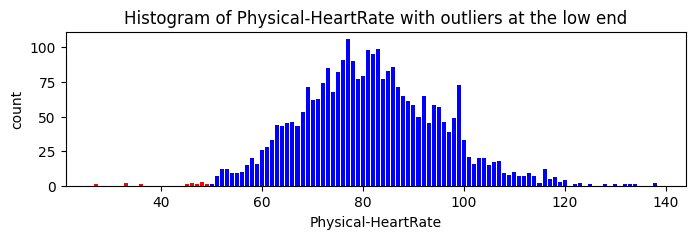

In [25]:
vc = train['Physical-HeartRate'].value_counts().sort_index()

color = np.where(vc.index < 50, 'r', 'b')

plt.figure(figsize=(8, 2))
plt.title('Histogram of Physical-HeartRate with outliers at the low end')
plt.bar(vc.index, vc.values, color=color)
plt.xlabel('Physical-HeartRate')
plt.ylabel('count')
plt.show()

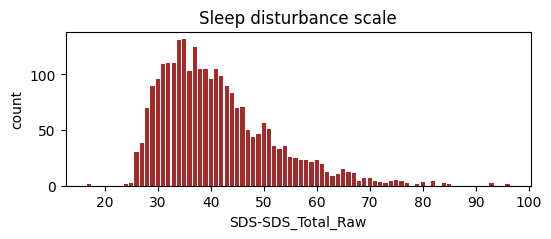

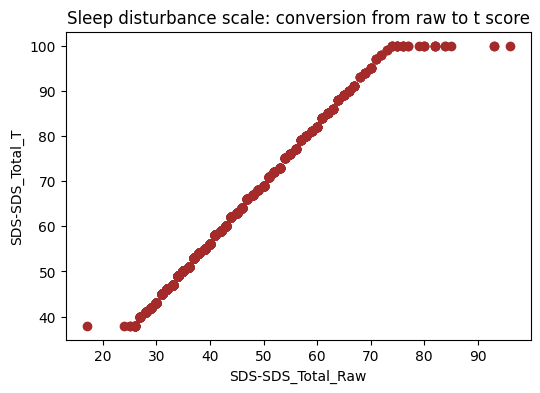

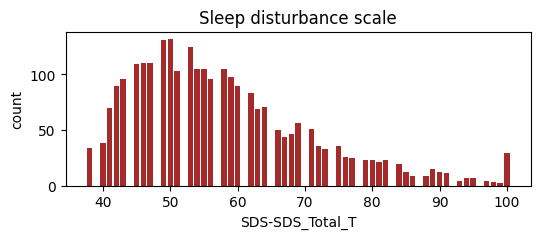

In [26]:
vc_raw = train['SDS-SDS_Total_Raw'].value_counts().sort_index()

plt.figure(figsize=(6, 2))
plt.title('Sleep disturbance scale')
plt.bar(vc_raw.index, vc_raw.values, color='brown')
plt.xlabel('SDS-SDS_Total_Raw')
plt.ylabel('count')
plt.show()

plt.figure(figsize=(6, 4))
plt.title('Sleep disturbance scale: conversion from raw to t score')
plt.scatter(train['SDS-SDS_Total_Raw'], train['SDS-SDS_Total_T'], color='brown')
plt.xlabel('SDS-SDS_Total_Raw')
plt.ylabel('SDS-SDS_Total_T')
plt.show()

vc_t = train['SDS-SDS_Total_T'].value_counts().sort_index()

plt.figure(figsize=(6, 2))
plt.title('Sleep disturbance scale')
plt.bar(vc_t.index, vc_t.values, color='brown')
plt.xlabel('SDS-SDS_Total_T')
plt.ylabel('count')
plt.show()

In [27]:
train['Physical-Height']

0       46.0
1       48.0
2       56.5
3       56.0
4        NaN
        ... 
3955    59.5
3956    53.5
3957    60.0
3958    70.7
3959     NaN
Name: Physical-Height, Length: 3960, dtype: float64

In [28]:
train['Physical-Height'] = train['Physical-Height'].apply(lambda x: None if pd.isna(x) else x)

In [29]:
count_none = train['Physical-Height'].isna().sum()
count_not_none = train['Physical-Height'].notna().sum()

data = pd.DataFrame({
    'Type': ['None', 'Not None'],
    'Count': [count_none, count_not_none]
})

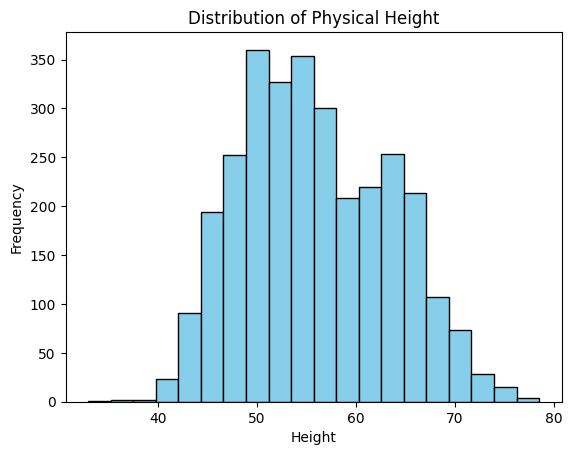

In [30]:
plt.hist(train['Physical-Height'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Physical Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

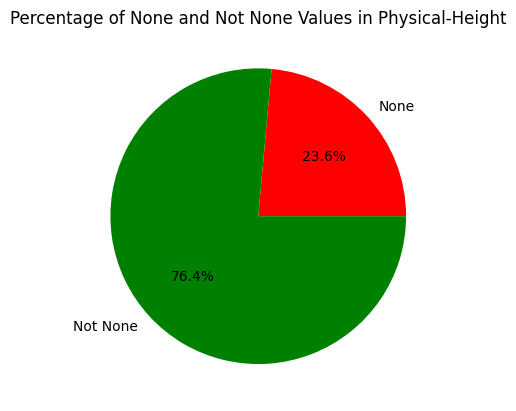

In [31]:
plt.pie(data['Count'], labels=data['Type'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Percentage of None and Not None Values in Physical-Height')
plt.show()

In [32]:
train['Physical-BMI']

0       16.877316
1       14.035590
2       16.648696
3       18.292347
4             NaN
          ...    
3955    16.362460
3956    18.764678
3957    21.441500
3958    12.235895
3959          NaN
Name: Physical-BMI, Length: 3960, dtype: float64

In [33]:
count_none = train['Physical-BMI'].isna().sum()
count_not_none = train['Physical-BMI'].notna().sum()

data = pd.DataFrame({
    'Type': ['None', 'Not None'],
    'Count': [count_none, count_not_none]
})

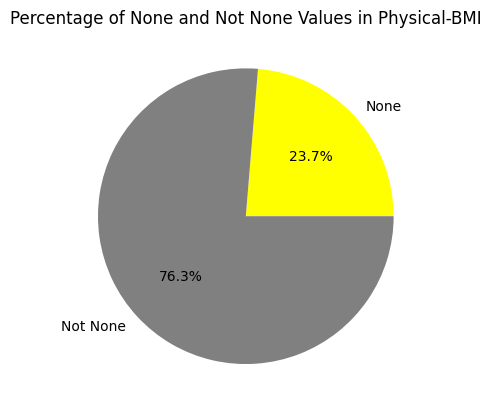

In [34]:
plt.pie(data['Count'], labels=data['Type'], autopct='%1.1f%%', colors=['yellow', 'grey'])
plt.title('Percentage of None and Not None Values in Physical-BMI')
plt.show()

In [35]:
count_none = train['Physical-Weight'].isna().sum()
count_not_none = train['Physical-Weight'].notna().sum()

data = pd.DataFrame({
    'Type': ['None', 'Not None'],
    'Count': [count_none, count_not_none]
})

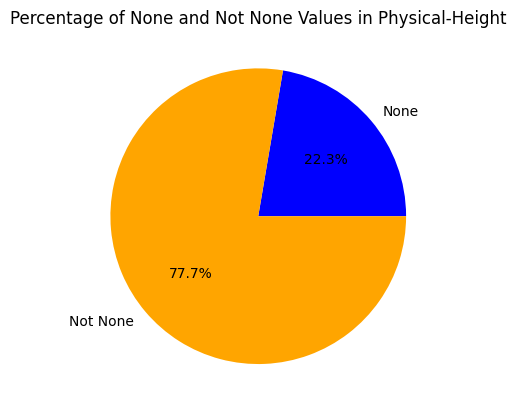

In [36]:
plt.pie(data['Count'], labels=data['Type'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Percentage of None and Not None Values in Physical-Height')
plt.show()

## Data Validation

- Schema check

In [37]:
print("Train Dimension: ", train.shape)
print("Test Dimension: ", test.shape)

Train Dimension:  (3960, 85)
Test Dimension:  (20, 59)


##  Data Cleaning & Feature Engineering

- Standarization

- Feature selection

In [38]:
def feature_engineering(df):
    df['Physical-Weight'] = df['Physical-Weight'].replace(0, np.nan)
    df['Physical-Height'] = df['Physical-Height'].replace(0, np.nan)
    df['Physical-BMI'] = df['Physical-BMI'].replace(0, np.nan)
    df['Basic_Demos-Age'] = df['Basic_Demos-Age'].replace(0, np.nan)
    df['Physical-Waist_Circumference'] = df['Physical-Waist_Circumference'].replace(0, np.nan)
    df['Physical-Diastolic_BP'] = df['Physical-Diastolic_BP'].replace(0, np.nan)
    df['Physical-HeartRate'] = df['Physical-HeartRate'].replace(0, np.nan)
    df['Physical-Systolic_BP'] = df['Physical-Systolic_BP'].replace(0, np.nan)

    df['Total_Fitness_Endurance_Time'] = np.where(
        df['Fitness_Endurance-Time_Mins'].isna() & df['Fitness_Endurance-Time_Sec'].isna(),
        np.nan,
        df['Fitness_Endurance-Time_Mins'].fillna(0) + df['Fitness_Endurance-Time_Sec'].fillna(0) / 60
    )
    df = df.drop("Fitness_Endurance-Time_Mins",axis=1)
    df = df.drop("Fitness_Endurance-Time_Sec",axis=1)
    return df

In [39]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                # 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday','Total_Fitness_Endurance_Time']

In [40]:
SEED = 42
n_splits = 5

# Data Filtering

In [41]:
def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')   
    return df
    
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']




In [42]:
train = feature_engineering(train)
test = feature_engineering(test)
label_column = train['sii']
train = train.drop('sii',axis=1)
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

- KNN Imputation

In [43]:
# Bước 1: Gộp train và test
all_data = pd.concat([train, test], axis=0)
# Bước 2: Xác định các cột numeric
numeric_cols = all_data.select_dtypes(include=['float64', 'int64']).columns
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(all_data[numeric_cols])

# Chuyển kết quả impute về DataFrame
all_data_imputed = pd.DataFrame(imputed_data, 
                                columns=numeric_cols, 
                                index=all_data.index)

# Bước 4: Khôi phục lại các cột không phải numeric
for col in all_data.columns:
    if col not in numeric_cols:
        all_data_imputed[col] = all_data[col]

# Bước 5: Tách lại tập train và test dựa trên index
train_imputed = all_data_imputed.iloc[:len(train)]
test_imputed = all_data_imputed.iloc[len(train):]

# Giờ bạn có train_imputed và test_imputed đã được impute
train = train_imputed
test = test_imputed

- Select training data for training model

In [44]:
train = train[featuresCols]
test = test[featuresCols]
train['sii'] = label_column
train = train.dropna(subset='sii')

- We don't use season feature for KNNImputation because they can make my model become overfiting so, add that feature after Imputation

In [45]:
def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)
for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

In [46]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)